### Mounting google drive

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### GPU 

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Feb 15 05:48:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### RAM

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('re-execute this cell.')
else:
  print('using a high-RAM runtime')

runtime has 27.4 gigabytes of available RAM

using a high-RAM runtime


### Adding import statements

In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from scipy.io import loadmat, savemat
import os
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [ ]:
#### Don't need to re-run ####
#pip install tensorflow

In [ ]:
print(tf.__version__)

2.4.1


### Reading train and validation set from file

In [ ]:
path_file_train = '/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/train_data_dict.pkl'
with open(path_file_train, 'rb' ) as handle:
    W = pickle.load(handle)
trainDict=W['train_dict']

In [ ]:
path_file_val = '/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/val_data_dict.pkl'
with open(path_file_val, 'rb' ) as handle:
    W = pickle.load(handle)
valDict=W['val_dict']

In [ ]:
train_obj_list=[]
train_dict_py={}

for key in trainDict.keys():
    (obj, obj_code)=trainDict[key]

    obj = obj.replace("C:\\data/grayscale/bike-data/bike_training/bike_train_pickles/","/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/train_data/")
    obj = obj.replace("C:\\data/grayscale/car-data/car_training/car_train_pickles/","/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/train_data/")
    obj = obj.replace("C:\\data/grayscale/ped-data/ped_training/ped_train_pickles/","/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/train_data/")


    train_obj_list.append(obj)
    train_dict_py[obj]=obj_code            


In [ ]:
len(train_dict_py)

900

In [ ]:
len(train_obj_list)

900

In [ ]:
#train_dict_py.keys()

In [ ]:
val_obj_list=[]
val_dict_py={}

for key in valDict.keys():
    (obj, obj_code)=valDict[key]

    obj = obj.replace("C:\\data/grayscale/bike-data/bike_training/bike_val_pickles/","/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/val_data/")
    obj = obj.replace("C:\\data/grayscale/car-data/car_training/car_val_pickles/","/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/val_data/")
    obj = obj.replace("C:\\data/grayscale/ped-data/ped_training/ped_val_pickles/","/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/val_data/")
    
    val_obj_list.append(obj)
    val_dict_py[obj]=obj_code    

In [ ]:
len(val_dict_py)

450

In [ ]:
len(val_obj_list)

450

In [ ]:
#train_dict_py

### Reading test set from file

In [ ]:
### Do not need to re-run ###
# !unzip '/content/gdrive/MyDrive/Classification/data/alltest.zip' -d '/content/gdrive/MyDrive/Classification/data/'
#!unzip '/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data.zip' -d '/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/'

In [ ]:
path_file_test = '/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data_dict.pkl'
with open(path_file_test, 'rb' ) as handle:
    W = pickle.load(handle)
testDict=W['test_dict']

In [ ]:
test_obj_list=[]
test_dict_py={}

for key in testDict.keys():
    (obj, obj_code)=testDict[key]


    obj = obj.replace("C:\\data/grayscale/bike-data/bike_test/bike_test_pickles/","/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/")
    obj = obj.replace("C:\\data/grayscale/car-data/car_test/car_test_pickles/","/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/")
    obj = obj.replace("C:\\data/grayscale/ped-data/ped_test/ped_test_pickles/","/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/")
    
    test_obj_list.append(obj)
    test_dict_py[obj]=obj_code

In [ ]:
len(test_dict_py)

22800

In [ ]:
len(test_obj_list)

22800

### Keras Data Generator

In [ ]:
import cv2

In [ ]:
### Keras data generator

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size, dim,n_classes, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        #self.n_channels= n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.indexes = np.arange(len(self.list_IDs))
        np.random.shuffle(self.indexes)

# TODO
    def __len__(self):
        'Denotes the number of batches per epoch'
        
        s=int(np.floor(len(self.list_IDs) / self.batch_size))
        
        return s  ### return s

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]


        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)



    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, 128,128,3))
        y = np.empty((self.batch_size), dtype=np.int)


        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample

            with open(ID, 'rb') as pf:
                temp = pickle.load(pf)
                stacked_temp = np.stack((temp,)*3, axis=-1)
                X[i,] = cv2.resize(stacked_temp, dsize=(128, 128), interpolation=cv2.INTER_AREA)
                

            # Store class
            y[i] = self.labels[ID]

        return X, to_categorical(y, num_classes=self.n_classes) 



### Parameters

In [ ]:
params = {'dim': (128,128,3),
          'batch_size': 32,
          'n_classes': 3,
          'shuffle': True}

#### building the data with data generators

In [ ]:
# training Generators
training_generator = DataGenerator(train_obj_list, train_dict_py, **params)

In [ ]:
# validation Generators
validation_generator = DataGenerator(val_obj_list, val_dict_py, **params)

In [ ]:
# test Generators
test_generator = DataGenerator(test_obj_list, test_dict_py, **params)

### Model

In [ ]:
# channel_last
# input shape = (128, 128, 3)
from tensorflow.keras import initializers
base_modelin=tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=(128,128,3), classes=3)
xin=base_modelin.output
xin=tf.keras.layers.GlobalAveragePooling2D(data_format=None)(xin)
#x=tf.keras.layers.Dropout(0.5)(xin)
xout=tf.keras.layers.Dense(3, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-5), 
                           activation = tf.nn.softmax, 
                           kernel_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.001))(xin)
model=tf.keras.models.Model(inputs=base_modelin.input, outputs=xout)
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision()])

94674944/94668760 [==============================] - 1s 0us/step


### callback

In [ ]:
#### Don't need to re-run ####
#pip install keras

In [ ]:
from keras import callbacks

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# Early stopping
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=1)
# patience=3
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

### Train the model

In [ ]:
history = model.fit_generator(generator=training_generator,
                    validation_data = validation_generator,
                              callbacks=[es],
                              verbose = 1,
                              epochs=50, 
                              use_multiprocessing=True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
28/28 [==============================] - 474s 17s/step - loss: 0.4824 - accuracy: 0.8282 - auc: 0.9360 - precision: 0.9359 - val_loss: 3292.2634 - val_accuracy: 0.3348 - val_auc: 0.5011 - val_precision: 0.3348
Epoch 2/50
28/28 [==============================] - 5s 177ms/step - loss: 0.2003 - accuracy: 0.9479 - auc: 0.9888 - precision: 0.9544 - val_loss: 330.6601 - val_accuracy: 0.5424 - val_auc: 0.6570 - val_precision: 0.5424
Epoch 3/50
28/28 [==============================] - 3s 117ms/step - loss: 0.0348 - accuracy: 0.9927 - auc: 0.9995 - precision: 0.9976 - val_loss: 959.8998 - val_accuracy: 0.3348 - val_auc: 0.5011 - val_precision: 0.3348
Epoch 4/50
28/28 [==============================] - 3s 122ms/step - loss: 0.0378 - accuracy: 0.9918 - auc: 0.9998 - precision: 0.9978 - val_loss: 125.7439 - val_accuracy: 0.3482 - val_auc: 0.5115 - val_precision: 0.3482
Epoch 5/50
28/28 [==============================] - 4s 138ms/step - loss: 0.0175 - accuracy: 0.9923 - auc: 0.9999 - pre

#### Saving the model

In [ ]:
# Result history for 300 per sample training data
# path: /content/gdrive/MyDrive/Classification/data/data_300_4
model.save('/content/gdrive/MyDrive/Classification/data/grayscale/data_300_4/model_300_4.h5')

In [ ]:
# Load the saved model
#model_300_2 = keras.models.load_model('/content/gdrive/MyDrive/Classification/data/grayscale/data_300_2/model_300_2.h5')

### Prediction on Validation Data

In [ ]:
# File's name : (ID)
validation_list_ID = validation_generator.list_IDs

In [ ]:
len(validation_list_ID)

450

In [ ]:
# File's name (ID)
ID_val = validation_generator.list_IDs[3]

In [ ]:
ID_val

'/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/val_data/bike_348_10.pkl'

In [ ]:
# y_true: actual value: labels[ID]
y_true = validation_generator.labels[validation_generator.list_IDs[3]]
print('y_true: ', y_true)

y_true:  0


In [ ]:
#Prediction 

pred_dict = {}
for i in range(450):
    ID_val = validation_generator.list_IDs[i]
    y_true = validation_generator.labels[ID_val]
    with open(ID_val, 'rb') as pf:
        temp_val = pickle.load(pf)
        stacked_temp_val = np.stack((temp_val,)*3, axis=-1)

        temp_val_resized = cv2.resize(stacked_temp_val, dsize=(128, 128), interpolation=cv2.INTER_AREA)
        
        # Expanding dimention
        temp_val_resized = np.expand_dims(temp_val_resized, axis=0)

        #Predic y_pred
        pred_val = model.predict(temp_val_resized)
        y_pred = int(np.argmax(pred_val, axis=-1))

        pred_dict[ID_val] = [y_true, y_pred] 
        print(i, ID_val, y_true, y_pred)

0 /content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/val_data/bike_57_14.pkl 0 0
1 /content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/val_data/car_218_7.pkl 1 1
2 /content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/val_data/ped_312_16.pkl 2 2
3 /content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/val_data/bike_348_10.pkl 0 0
4 /content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/val_data/car_339_19.pkl 1 1
5 /content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/val_data/ped_155_8.pkl 2 2
6 /content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/val_data/bike_188_4.pkl 0 0
7 /content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/val_data/car_214_1.pkl 1 1
8 /content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/val_data/ped_154_1.pkl 2 2
9 /content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/val_data/bike_180_1.pkl 0 0
10 /content/gdrive/MyDrive/Classification/data/graysc

In [ ]:
pred_dict_300_4 = pred_dict

In [ ]:
len(pred_dict_300_4.keys())

450

In [ ]:
actual_300_4 = []
predicted_300_4 = []
for key in pred_dict_300_4.keys():
                actual_300_4.append(pred_dict_300_4[key][0])
                predicted_300_4.append(pred_dict_300_4[key][1])

### Confusion Matrix (Validation)

In [ ]:
# classification report for precision, recall f1-score and accuracy
from sklearn.metrics import classification_report
report_matrix = classification_report(actual_300_4, predicted_300_4,labels=[0,1,2])
print('Classification report : \n',report_matrix)

Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       1.00      0.99      1.00       150
           2       0.99      1.00      1.00       150

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450



In [ ]:
# confusion matrix
cf_matrix = confusion_matrix(actual_300_4, predicted_300_4, labels=[0,1,2])
print('Confusion matrix : \n',cf_matrix)

Confusion matrix : 
 [[150   0   0]
 [  0 149   1]
 [  0   0 150]]


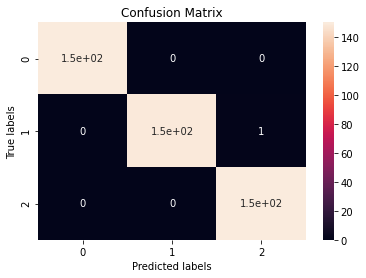

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
#ax.xaxis.set_ticklabels(['bike', 'car', 'ped']); ax.yaxis.set_ticklabels(['bike', 'car', 'ped']);

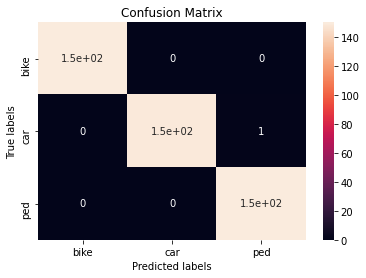

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['bike', 'car', 'ped']); ax.yaxis.set_ticklabels(['bike', 'car', 'ped']);

### Unmatched Results (Validation)

In [ ]:
unmatched_results_300_4 = []
for key in pred_dict_300_4.keys():
               if (pred_dict_300_4[key][0] != pred_dict_300_4[key][1]):
                item = (key, pred_dict_300_4[key][0], pred_dict_300_4[key][1])
                unmatched_results_300_4.append(item)
                

In [ ]:
len(unmatched_results_300_4)

1

In [ ]:
unmatched_results_300_4

[('/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/val_data/car_31_13.pkl',
  1,
  2)]

### Visualize Unmatched Results

In [ ]:
# '/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/val_data/car_31_13.pkl',1,2)]
pf1 = '/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/val_data/car_31_13.pkl' 
with open(pf1, 'rb') as handle1:
    unmatched1 = pickle.load(handle1)

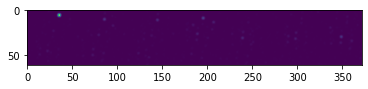

In [ ]:
plt.imshow(unmatched1)

#### Visualize matched Results

In [ ]:
# 429: 0 0
pf1 = '/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/val_data/bike_88_18.pkl' 
with open(pf1, 'rb') as handle1:
    matched1 = pickle.load(handle1)

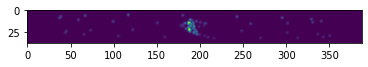

In [ ]:
plt.imshow(matched1)

In [ ]:
# 79: 1 1
pf2 = '/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/val_data/car_387_6.pkl'
with open(pf2, 'rb') as handle2:
    matched2 = pickle.load(handle2)

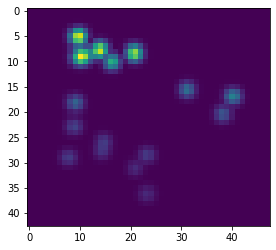

In [ ]:
plt.imshow(matched2)

In [ ]:
# 179 : 2 2
pf3 = '/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/val_data/ped_144_1.pkl'
with open(pf3, 'rb') as handle3:
    matched3 = pickle.load(handle3)

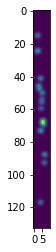

In [ ]:
plt.imshow(matched3)

#### Saving the history of the results

In [ ]:
#history.history.keys()

In [ ]:
# Result history for 300 per sample training data
histDict_300_4 = history.history

In [ ]:
type(histDict_300_4)

dict

In [ ]:
histDict_300_4.keys()

dict_keys(['loss', 'accuracy', 'auc', 'precision', 'val_loss', 'val_accuracy', 'val_auc', 'val_precision'])

In [ ]:
#### Don't need to re-run ####
#pip install plot_keras_history

### accuracy

In [ ]:
acc_300_4 = histDict_300_4['accuracy']
print(acc_300_4)

[0.8962053656578064, 0.9676339030265808, 0.9888392686843872, 0.9910714030265808, 0.9966517686843872, 0.9877232313156128, 0.9977678656578064, 0.9910714030265808, 0.9944196343421936, 0.9799107313156128, 0.9966517686843872, 0.9944196343421936, 0.9910714030265808, 0.9988839030265808, 0.9988839030265808, 0.9966517686843872, 0.9966517686843872, 0.9944196343421936, 0.9977678656578064, 1.0, 0.9988839030265808, 1.0, 0.9988839030265808, 1.0, 1.0, 1.0, 1.0, 1.0]


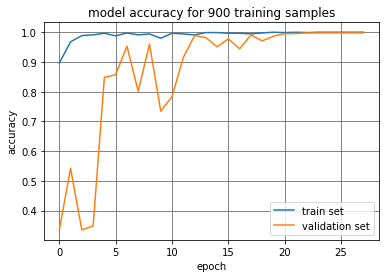

In [ ]:
# summarize accuracy history for histDict_300_2

import matplotlib.pyplot as plt
plt.plot(histDict_300_4['accuracy'])
plt.plot(histDict_300_4['val_accuracy'])
plt.title('model accuracy for 900 training samples')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train set', 'validation set'], loc = 'lower right')
# Show the grid lines as dark grey lines
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.show()

### Loss

In [ ]:
loss_300_4 = histDict_300_4['loss']
print(loss_300_4)

[0.31288760900497437, 0.12335540354251862, 0.05862773209810257, 0.032016634941101074, 0.012136748991906643, 0.03594556450843811, 0.014525426551699638, 0.034310441464185715, 0.014421626925468445, 0.06885258853435516, 0.01053831446915865, 0.01018961425870657, 0.025125812739133835, 0.0157748032361269, 0.010481348261237144, 0.007425452116876841, 0.009978896006941795, 0.022522738203406334, 0.008088801987469196, 0.004690558649599552, 0.0035607514437288046, 0.0020587043836712837, 0.0029511465691030025, 0.00217459793202579, 0.0009476019185967743, 0.0008894928032532334, 0.0007199247484095395, 0.0008367012487724423]


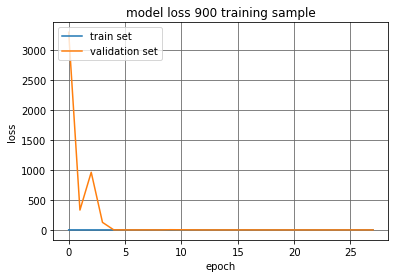

In [ ]:
# summarize loss history for histDict_300_2

plt.plot(histDict_300_4['loss'])
plt.plot(histDict_300_4['val_loss'])
plt.title('model loss 900 training sample')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train set', 'validation set'], loc = 'upper left')
# Show the grid lines as dark grey lines
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.show()

### Precision

In [ ]:
precision_300_4 = histDict_300_4['precision']
print(precision_300_4)

[0.9519480466842651, 0.9733487963676453, 0.9932432174682617, 0.9966177940368652, 0.9977553486824036, 0.9876819849014282, 0.998881459236145, 0.9910414218902588, 0.9944196343421936, 0.9798882603645325, 0.9988802075386047, 0.9955307245254517, 0.9921700358390808, 0.9988839030265808, 0.9988839030265808, 0.9966517686843872, 0.9966517686843872, 0.9944196343421936, 0.9977678656578064, 1.0, 0.9988839030265808, 1.0, 0.9988839030265808, 1.0, 1.0, 1.0, 1.0, 1.0]


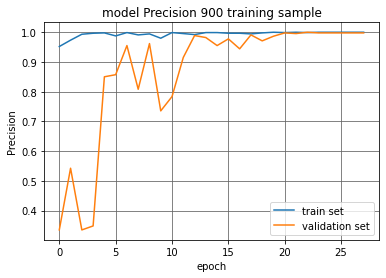

In [ ]:
# summarize precision history for histDict_300_1

plt.plot(histDict_300_4['precision'])
plt.plot(histDict_300_4['val_precision'])
plt.title('model Precision 900 training sample')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train set', 'validation set'], loc = 'lower right')
# Show the grid lines as dark grey lines
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.show()


### AUC

In [ ]:
auc_300_4 = histDict_300_4['auc']
print(auc_300_4)

[0.97669517993927, 0.9956879019737244, 0.9978078007698059, 0.9997680187225342, 0.999984085559845, 0.9996942281723022, 0.9999206066131592, 0.998854398727417, 0.9999565482139587, 0.9975358247756958, 0.999990701675415, 0.9999794363975525, 0.999030351638794, 0.9990857243537903, 0.9991374015808105, 0.9999906420707703, 0.999980092048645, 0.9997860789299011, 0.9999622702598572, 1.0, 0.999999463558197, 1.0, 0.9999993443489075, 1.0, 1.0, 1.0, 0.9999999403953552, 0.9999999403953552]


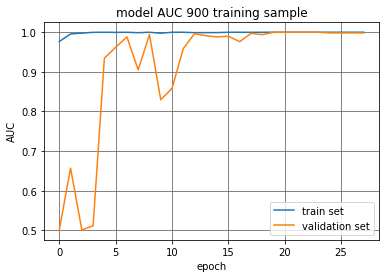

In [ ]:
# summarize auc history for histDict_300_2

plt.plot(histDict_300_4['auc'])
plt.plot(histDict_300_4['val_auc'])
plt.title('model AUC 900 training sample')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train set', 'validation set'], loc = 'lower right')
# Show the grid lines as dark grey lines
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.show()


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
viz_model_300_4 = keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#### Don't need to re-run ####
#pip install pydot

In [ ]:
#### Don't need to re-run ####
#conda install -c anaconda graphviz

In [ ]:
#viz_model_300_4

### Test Set

### Prediction on the test set

In [ ]:
#Prediction on test set

test_pred_dict = {}
for i in range(22800):
    ID_test = test_generator.list_IDs[i]
    y_true = test_generator.labels[ID_test]
    with open(ID_test, 'rb') as pf:
        temp_test = pickle.load(pf)
        stacked_temp_test = np.stack((temp_test,)*3, axis=-1)
        temp_test_resized = cv2.resize(stacked_temp_test, dsize=(128, 128), interpolation=cv2.INTER_AREA)

        # Expanding dimention
        temp_test_resized = np.expand_dims(temp_test_resized, axis=0)

       
        #Predic y_pred
        pred_test = model.predict(temp_test_resized)
        y_pred = int(np.argmax(pred_test, axis=-1))

        test_pred_dict[ID_test] = [y_true, y_pred] 
        print(i, ID_test, y_true, y_pred)

Streaming output truncated to the last 5000 lines.
17800 /content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/car_790_13.pkl 1 1
17801 /content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/ped_715_5.pkl 2 2
17802 /content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/bike_743_8.pkl 0 0
17803 /content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/car_421_15.pkl 1 1
17804 /content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/ped_205_4.pkl 2 2
17805 /content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/bike_506_13.pkl 0 0
17806 /content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/car_221_6.pkl 1 1
17807 /content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/ped_184_16.pkl 2 2
17808 /content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/bike_712_12.pkl 0 0
17809 /content/gdrive/MyDrive/Classification/data/

In [ ]:
test_pred_dict_300_4 = test_pred_dict

In [ ]:
len(test_pred_dict_300_4)

22800

In [ ]:
test_actual_300_4 = []
test_predicted_300_4 = []
for key in test_pred_dict_300_4.keys():
                test_actual_300_4.append(test_pred_dict_300_4[key][0])
                test_predicted_300_4.append(test_pred_dict_300_4[key][1])

### Confusion matrix for test set

In [ ]:
# classification report for precision, recall f1-score and accuracy
from sklearn.metrics import classification_report
report_matrix = classification_report(test_actual_300_4,test_predicted_300_4,labels=[0,1,2])
print('Classification report : \n',report_matrix)

Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7600
           1       1.00      0.99      0.99      7600
           2       1.00      1.00      1.00      7600

    accuracy                           1.00     22800
   macro avg       1.00      1.00      1.00     22800
weighted avg       1.00      1.00      1.00     22800



In [ ]:
# confusion matrix
cf_matrix = confusion_matrix(test_actual_300_4, test_predicted_300_4, labels=[0,1,2])
print('Confusion matrix : \n',cf_matrix)

Confusion matrix : 
 [[7591    9    0]
 [  18 7550   32]
 [   0   17 7583]]


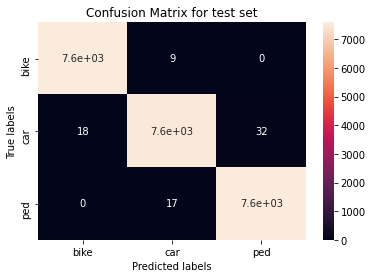

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for test set'); 
ax.xaxis.set_ticklabels(['bike', 'car', 'ped']); ax.yaxis.set_ticklabels(['bike', 'car', 'ped']);

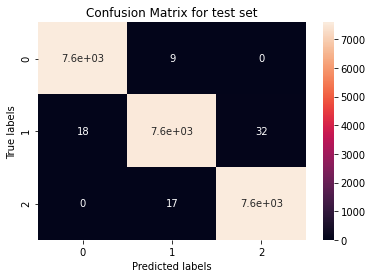

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for test set'); 
#ax.xaxis.set_ticklabels(['bike', 'car', 'ped']); ax.yaxis.set_ticklabels(['bike', 'car', 'ped']);

### Unmatched test results

In [ ]:
test_unmatched_results_300_4 = []
for key in test_pred_dict_300_4.keys():
               if (test_pred_dict_300_4[key][0] != test_pred_dict_300_4[key][1]):
                item = (key, test_pred_dict_300_4[key][0], test_pred_dict_300_4[key][1])
                test_unmatched_results_300_4.append(item)

In [ ]:
len(test_unmatched_results_300_4)

76

In [ ]:
test_unmatched_results_300_4

[('/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/car_208_10.pkl',
  1,
  2),
 ('/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/bike_574_15.pkl',
  0,
  1),
 ('/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/ped_97_11.pkl',
  2,
  1),
 ('/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/ped_22_3.pkl',
  2,
  1),
 ('/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/car_214_16.pkl',
  1,
  2),
 ('/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/car_207_3.pkl',
  1,
  2),
 ('/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/car_597_2.pkl',
  1,
  0),
 ('/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/car_215_2.pkl',
  1,
  0),
 ('/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/car_208_15.pkl',
  1,
  2),
 ('/content/gdrive/MyDrive/Classification/data/gray

#### Visualize Unmatched Results *

In [ ]:
# '/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/bike_599_5.pkl',0,1
pf1 = '/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/bike_599_5.pkl'

In [ ]:
with open(pf1, 'rb') as handle1:
    unmatched1 = pickle.load(handle1)

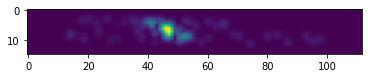

In [ ]:
plt.imshow(unmatched1)

In [ ]:
# '('/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/car_710_16.pkl',1,0),
pf2 = '/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/car_710_16.pkl'
with open(pf2, 'rb') as handle2:
    unmatched2 = pickle.load(handle2)

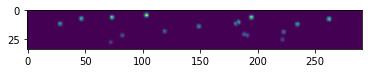

In [ ]:
plt.imshow(unmatched2)

In [ ]:
# ''/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/car_153_10.pkl',1,2),
pf3 = '/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/car_153_10.pkl'
with open(pf3, 'rb') as handle3:
    unmatched3 = pickle.load(handle3)

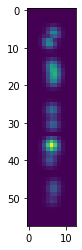

In [ ]:
plt.imshow(unmatched3)

In [ ]:
# '/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/ped_22_3.pkl',2,1),
pf4 = '/content/gdrive/MyDrive/Classification/data/grayscale/data_300_1/test_data/ped_22_3.pkl'
with open(pf4, 'rb') as handle4:
    unmatched4 = pickle.load(handle4)

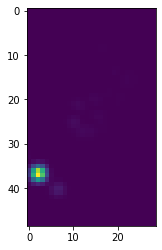

In [ ]:
plt.imshow(unmatched4)

### Scores for test set

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_actual_300_4, test_predicted_300_4)

0.9966666666666667

In [ ]:
from sklearn.metrics import precision_score	
metrics.precision_score(test_actual_300_4, test_predicted_300_4, average='macro')

0.9966667525745253